In [0]:
#Se importan las librerías a utilizar en el desarrollo del ejercicio
import pandas as pd
import numpy as np
import random

#Gráficos
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus
from sklearn.tree import export_graphviz

#ML
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import make_scorer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


Using TensorFlow backend.


* El dataset inscripción corresponde al listado de personas que se inscriben en el programa "Salud Visual" de la Alcaldía de Medellín el cual busca asignar recursos del presupuesto participativo a la atención visual sobre las personas mayores de 18 años
* El dataset atención corresponde al listado de pacientes atendidos en el programa "Salud Visual"
* El dataset síntomas corresponde al análisis del campo descripción del dataset inscripción, las cuales fueron procesadas en Atlas TI para determinar molestias claves en los pacientes

In [0]:
atencion = pd.read_excel('ATENCIONES_D.xlsx',sheet_name='ATENCIONES', skiprows = 1)
inscripcion = pd.read_excel('ATENCIONES_D.xlsx',sheet_name='INSCRITOS')
sintomas = pd.read_excel('Sintomas.xlsx',sheet_name='sintomas')

Integración de bases de datos de atención, inscripción y síntomas

In [0]:
inscritos_sintomas = inscripcion.merge(sintomas, on = ['ID','Ficho_Inscripcion'], how = 'left' )

In [0]:
inscritos_sintomas.shape

(11819, 40)

In [0]:
#Se integran los sintomas al dataset
optometria_raw = atencion.merge(inscritos_sintomas, on = 'ID')

In [0]:
optometria_raw.shape

(8117, 78)

Análisis general de los datos numéricos 

In [23]:
optometria_raw.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
CONSECUTIVO,8117.0,4.693665e+04,2.799182e+03,4545.0,44567.0,47136.0,49200.0,6.197700e+04
ID,8117.0,5.834048e+12,7.265636e+13,191914.0,42685708.0,43539446.0,71738139.0,9.636632e+14
EDAD,8117.0,4.799101e+01,1.459680e+01,0.0,39.0,51.0,57.0,9.900000e+01
CONSULTA,8117.0,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.000000e+00
ESTUCHE Y PAÑO,7762.0,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.000000e+00
MONTURA,7762.0,1.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.000000e+00
EJE-OD,4608.0,6.829959e+01,5.156474e+01,0.0,15.0,80.0,95.0,1.800000e+02
2\nLentes monofocales en CR-39 tallados,8110.0,3.526510e-02,2.350248e-01,0.0,0.0,0.0,0.0,2.000000e+00
3\nLentes monofocales en policarbonato terminados\n,8110.0,1.086313e-01,4.435443e-01,0.0,0.0,0.0,0.0,2.000000e+00
5\nLentes bifocales flat top CR-39 terminados,8117.0,2.266847e-02,1.960141e-01,0.0,0.0,0.0,0.0,2.000000e+00


Del análisis preliminar de la información de los pacientes atendidos, se depuran las variables que no están categorizadas en función del diagnóstico

Características usadas para generar cobro
* Tipo de lente
* Total lentes unitarios
* Valor_usuario
* Referencia_montura
* Lentes monofocales en CR-39 terminados
* Lentes monofocales en CR-39 tallados
* Lentes monofocales en policarbonato terminados
* Lentes monofocales en policarbonato tallado
* Lentes bifocales flat top CR-39 terminados
* Lentes bifocales flat top CR-39 tallados
* Lentes bifocales flat top policarbonato
* Lentes bifocales invisible CR-39 terminados
* Lentes bifocales invisible CR-39 tallados
* Lentes bifocales invisible policarbonato
* Lentes progresivos en CR-39
* Lentes progresivos en policarbonato

Caraterísticas de identificación
* Consecutivo. Corresponde al id entregado en la atención y no aporta información al modelo
* Ficho de inscripcion
* Direccion Residencia
* Fecha de nacimiento
* Tipo de documento
* Barrio
* Direccion Correspondencia
* Sisben 
* Descripcion

Características de uso administrativo de la Alcaldía de Medellín
* Poblacion
* Etnia. 
* Ocupación. 


El diagnóstico Z010 corresponde a una consulta de optometría que no tuvo un diagnóstico principal

Selección de características a partir del juicio del experto

Estás características son las que quedan luego de retirar las variables que no están en función del análisis

In [0]:
columnas = ['EDAD','CONSULTA','ESTUCHE Y PAÑO','MONTURA', 'DX\nPPAL\nCIE 10','ESFERA-OD','CILINDRO-OD','EJE-OD','ADD-OD','ESFERA-OI','CILINDRO-OI','EJE-OI','ADD-OI','Genero','Exam_ojos','Usa_Gafas','Tiem_gafas','Glaucoma','Enfermedad','Picazón_irritación_Ardor', 'Ojos_cansados_doloridos', 'Ojos_llorosos', 'Ojos_secos', 'Visión_borrosa', 'Visión_doble', 'Mayor_sensibilidad_a_la_luz',
'Dificultad_para_ver', 'Dificultad_para_leer_letras_pequeñas', 'Leer_a_una_distancia_mayor_', 'Secreciones_(Pus_o_mucosidad)',      'Leer_a_una_distancia_menor_', 'Ojos_Enrojecidos', 'Mareos_migraña_y_vomito', 'Inflamación', 'Temblor_en_los_ojos',       'Cestelleos_manchas_flotantes_y_desprendimiento_de_la_retina','ID']

In [0]:
optometria_dep = optometria_raw[columnas]

Ajuste de forma a nivel de encabezado

In [0]:
optometria_dep.rename(columns={'DX\nPPAL\nCIE 10':'Diagnostico'}, inplace = True)
optometria_dep.rename(str.lower, axis='columns', inplace = True)

Depuración y Análisis de los datos

In [0]:
#Se borran los registros duplicados por id en caso de que existan
optometria_dep.drop_duplicates('id', keep = 'last', inplace = True)

In [28]:
optometria_dep.shape

(8117, 37)

In [0]:
#Se eliminan toda aquellas filas que contengan en todos su campos valores nulos
optometria_dep.dropna(how = 'all', inplace = True)

In [30]:
optometria_dep.shape

(8117, 37)

EDAD
La edades oscilan entre los 19 a 81 anios, teniendo unos valores atipicos atipicos por encima de 81 anios y de cero anios.
En la fuente de datos, la edad más frecuente es 59

In [31]:
optometria_dep['edad'].describe()

count    8117.000000
mean       47.991007
std        14.596800
min         0.000000
25%        39.000000
50%        51.000000
75%        57.000000
max        99.000000
Name: edad, dtype: float64

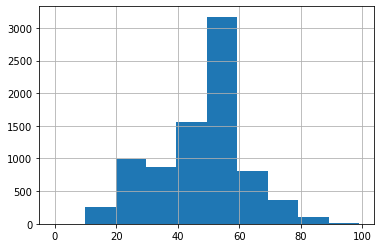

In [32]:
optometria_dep['edad'].hist() 

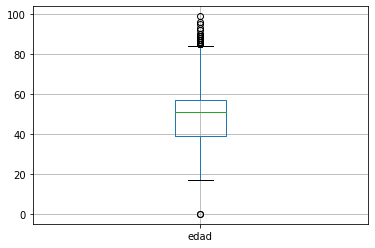

In [33]:
optometria_dep.boxplot('edad')

Se revisan los outliers de edad. El programa "Salud Visual" esta diseñado para mayores de edad, por lo tanto se restringuen los valores del data frame bajo este criterio

In [0]:
optometria_dep.drop(optometria_dep[optometria_dep['edad'] < 18].index, axis = 0, inplace = True)

In [35]:
optometria_dep.shape

(8114, 37)

La columna consulta toma el valor de 1, lo cual quiere decir que fue atendido, dado que hay poca varibilidad se considera candidata a eliminar

In [36]:
optometria_dep['consulta'].describe()

count    8114.0
mean        1.0
std         0.0
min         1.0
25%         1.0
50%         1.0
75%         1.0
max         1.0
Name: consulta, dtype: float64

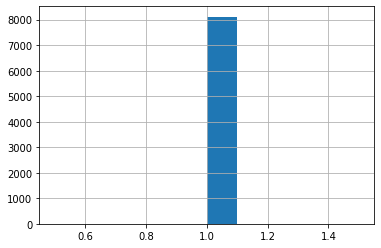

In [37]:
optometria_dep['consulta'].hist() 

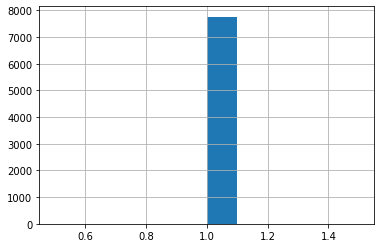

In [38]:
optometria_dep['estuche y paño'].hist()

In [39]:
optometria_dep['estuche y paño'].unique()

array([ 1., nan])

Se completan los valores nulos de algunas características, teniendo en cuenta que los valores de 1 y 0 corresponden a Si y No respectivamente

In [0]:
values_em = {'estuche y paño': 0, 'montura' : 0, 'esfera-od':0, 'cilindro-od':0, 'eje-od':0, 'add-od':0, 'esfera-oi':0,
'cilindro-oi':0, 'eje-oi':0, 'add-oi':0, 'picazón_irritación_ardor':0, 'ojos_cansados_doloridos':0, 'ojos_llorosos':0,
'ojos_secos':0, 'visión_borrosa':0, 'visión_doble':0, 'mayor_sensibilidad_a_la_luz':0, 'dificultad_para_ver':0,
'dificultad_para_leer_letras_pequeñas':0, 'leer_a_una_distancia_mayor_':0, 'secreciones_(pus_o_mucosidad)':0, 
'leer_a_una_distancia_menor_':0, 'ojos_enrojecidos':0, 'mareos_migraña_y_vomito':0, 'inflamación':0,
'temblor_en_los_ojos':0,'cestelleos_manchas_flotantes_y_desprendimiento_de_la_retina':0}

In [0]:
optometria_dep.fillna(value = values_em, inplace = True)

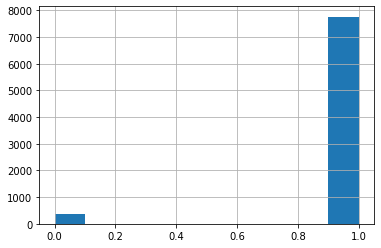

In [43]:
optometria_dep['montura'].hist()

In [44]:
optometria_dep.groupby(['montura'])['montura'].count()

montura
0.0     355
1.0    7759
Name: montura, dtype: int64

In [45]:
optometria_dep.groupby(['estuche y paño'])['estuche y paño'].count()

estuche y paño
0.0     355
1.0    7759
Name: estuche y paño, dtype: int64

Las variables estuche y paño y montura indican que al paciente le recetaron gafas, por lo tanto se puede agrupar en usa sola dimensión.


In [0]:
optometria_dep['requiere_gafas'] = np.where((optometria_dep['estuche y paño'] == 1) & (optometria_dep['montura'] == 1),1,0) #1 Tiene gafas, 0 no tiene
optometria_dep['requiere_gafas'].hist()

Los diagnósticos con mayor frecuencia en el estudio realizado en el 2019 son H524 - Presbicia, H522 - Astigmatismo, H521 - Miopía. 

El diagnóstico Z010 significa que el paciente fue diagnosticado sin enfermedad visual.

In [0]:
optometria_dep['diagnostico'] = optometria_dep['diagnostico'].str.upper()
optometria_dep['diagnostico'].hist(figsize = (17,5))

In [49]:
optometria_dep['diagnostico'].unique()

array(['H524', 'H522', 'H521', 'H520', 'H500', 'H525', 'Z010', 'H269',
       ' H524', 'H268', 'H52', 'H110', 'ZO10', 'H264', 'H101', 'H22', nan,
       'H50', 'H420', 'H502', 'H24', 'H54', 'H21', 'DA151'], dtype=object)

Se depuran los registros que no tienen diagnóstico, en caso de que existan

In [0]:
optometria_dep.drop(optometria_dep[optometria_dep['diagnostico'].isnull()].index, axis = 0, inplace = True)

In [51]:
optometria_dep.shape

(8113, 38)

Análisis de medidas visuales

* El valor de balance se refiere a cuando un ojo no recupera visión, el optometra le asigna una fórmula similar a la del otro ojo 
* N significa neutro y toma valor a cero
* Los valores impracticable y no aplica significan que el examen por alguna razón no se puedo prácticar, se eliminan los registros que tomen ese valor del todo el dataset

In [52]:
optometria_dep['esfera-od'].unique()

array([2, 'N', -1, 1.5, -0.25, 2.75, -1.25, 3.5, -0.5, 0.25, 1, 0.75,
       3.25, 0.5, 1.25, -1.5, -3, 2.5, 1.75, -2.75, 3, -0.75, -6, -2.5,
       -2, 2.25, -8.5, -3.5, 4, '-0.25', -7, 0, 4.5, -0.258, -7.5, 5.5,
       -4.5, 3.75, 5, -1.75, -4.25, -3.25, -7.25, -4, -11, -4.75, 4.25,
       -6.5, -2.25, 6, -8, -9, -5, 'NO APLICA ', -5.5, 6.5, -12, -14, 7,
       6.75, -6.75, 10, -11.5, 9, 2.501, -3.75, -6.25, 'BALANCE ', 0.501,
       '-15.00', -18, '-0.50', '-8.00', '-7.00', ' N', '-1.00', -8.75,
       -11.75, 'IMPRACTICABLE ', -8.25, 5.25, 8, 4.75, 'n', -5.75, 7.5,
       8.5, -19, -15, -1.74, -20, 6.25, 1.56], dtype=object)

In [0]:
optometria_dep['esfera-od'] = np.where((optometria_dep['esfera-od']  == 'N') | (optometria_dep['esfera-od']  == 'n') | (optometria_dep['esfera-od']  == ' N') | (optometria_dep['esfera-od']  == 'N ') | (optometria_dep['esfera-od']  == ' n') | (optometria_dep['esfera-od']  == 'n '), 0.0, optometria_dep['esfera-od'])
optometria_dep['esfera-od'] = np.where((optometria_dep['esfera-od']  == 'BALANCE') | (optometria_dep['esfera-od']  == 'BALANCE '), optometria_dep['esfera-oi'], optometria_dep['esfera-od']) 

In [0]:
optometria_dep.drop((optometria_dep[optometria_dep['esfera-od'] == 'IMPRACTICABLE'].index) | (optometria_dep[optometria_dep['esfera-od'] == 'IMPRACTICABLE '].index) | (optometria_dep[optometria_dep['esfera-od'] == 'NO APLICA '].index) | (optometria_dep[optometria_dep['esfera-od'] == 'NO APLICA '].index), axis = 0, inplace = True)

In [55]:
optometria_dep['cilindro-od'].unique()

array([-0.5, -0.75, -2.5, 0, -1, -0.25, -1.5, -3, -3.5, -4.5, -1.25, -2,
       -1.75, '-2.00', -2.25, -2.75, -3.25, -5, ' ', -5.5, '-1.25', -4,
       -4.75, -6, '-0.75', '-5.00', -7, -3.75, '-0.50', -0.258, '-7.00',
       '-1.00', '-1.50', '-2.50', -0.59, 'BALANCE', -3.2, 'BALANCE ',
       -1.2, -0.6, -2.752, -6.5, -0.754], dtype=object)

In [0]:
optometria_dep['cilindro-od'] = np.where((optometria_dep['cilindro-od']  == 'BALANCE') | (optometria_dep['cilindro-od']  == 'BALANCE '), optometria_dep['cilindro-oi'], optometria_dep['cilindro-od']) 
optometria_dep['cilindro-od'] = np.where((optometria_dep['cilindro-od'] == ' '), 0.0, optometria_dep['cilindro-od'])

In [57]:
optometria_dep['add-od'].unique()

array([0, 2.75, 2, 2.25, 1.25, 1.75, 1.5, 2.5, 3, 1, -1, '   ', 2.275,
       ' ', 0.75, 3.5, -1.75, -2.5, 1.45, -1.5, 2.26], dtype=object)

In [0]:
#optometria_dep['add-od'] = optometria_dep['add-od'].str.strip()
optometria_dep['add-od'] = np.where((optometria_dep['add-od'] == '   ') | (optometria_dep['add-od'] == ' '), 0.0 ,optometria_dep['add-od'])

In [59]:
optometria_dep['esfera-oi'].unique()

array([2, -0.5, -1, 1.25, 'N', -0.25, 2.75, -2.5, 0.25, 3.75, 1.5, 1, 0.5,
       0.75, -1.75, 2.5, -1.5, 2.25, -1.25, -0.75, 1.75, 3, -5.5, -2,
       -3.75, 4, -7, 4.5, 0, -6, -7.5, 5, -4, -4.5, 3.5, 3.25, '-0.25',
       -10, 5.5, -8, -4.25, -3, -6.5, -6.25, '-5.00', 'N ', -3.25, -5,
       -2.25, 6.5, -3.5, -2.75, 6, -7.75, -9, -13, 6.75, -8.5, 11, -12,
       7.5, 0.501, -5.75, ' N', 4.25, -4.75, -15.75, -18, 1.2, '-1.00', 7,
       4.75, 0.72, -1.72, 10, 8, 5.25, 'n', 10.5, -14, -19, -15, -20, 8.5,
       0.025, -1.74, 5.75, -10.5], dtype=object)

In [0]:
optometria_dep['esfera-oi'] = np.where((optometria_dep['esfera-oi']  == 'N') | (optometria_dep['esfera-oi']  == ' N') | (optometria_dep['esfera-oi']  == 'N ') | (optometria_dep['esfera-oi']  == 'n') | (optometria_dep['esfera-oi']  == ' n') | (optometria_dep['esfera-oi']  == 'n '), 0.0, optometria_dep['esfera-oi'])

optometria_dep.drop((optometria_dep[optometria_dep['esfera-oi'] == 'NO APLICA '].index) | (optometria_dep[optometria_dep['esfera-oi'] == 'NO APLICA'].index), axis = 0, inplace = True)

In [61]:
optometria_dep['cilindro-oi'].unique() 

array([-0.25, 0, -2.5, -0.75, -0.5, -1.25, -1, -1.5, -4, -6.5, -2, -1.75,
       -2.75, -4.5, -2.25, '-2.00', 'N', -4.25, -3, -3.75, -3.5, -4.75,
       '-0.50', -5, 0.5, -5.75, 'BALANCE', -5.5, -0.5018, -0.50135, -7,
       -3.25, 0.75, 0.25, '-1.00', '-1.50', '-0.75', 'BALANCE ', 1.5, -8,
       -6, 2.25], dtype=object)

In [0]:
optometria_dep['cilindro-oi'] = np.where((optometria_dep['cilindro-oi']  == 'N'), 0.0, optometria_dep['cilindro-oi'])

optometria_dep['cilindro-oi'] = np.where((optometria_dep['cilindro-oi']  == 'BALANCE') | (optometria_dep['cilindro-oi']  == 'BALANCE '), optometria_dep['cilindro-od'], optometria_dep['cilindro-oi']) 

In [63]:
optometria_dep['eje-od'].unique()

array([100.  ,  70.  ,   5.  ,   0.  ,  90.  ,  40.  , 105.  ,  50.  ,
        30.  ,  80.  ,  10.  , 160.  ,  25.  ,  95.  , 170.  ,  20.  ,
        75.  ,  60.  ,  45.  ,  85.  ,  15.  , 135.  , 110.  , 175.  ,
       115.  , 120.  , 165.  ,  35.  , 130.  , 155.  , 125.  , 150.  ,
       140.  ,  55.  ,  65.  , 145.  ,   0.25, 180.  ,   2.  ,   3.  ,
        12.  ,  76.  , 168.  ,   2.25])

In [64]:
optometria_dep['eje-oi'].unique()

array([80, 0, 15, 50, 90, 5, 160, 10, 150, 170, 115, 140, 120, 60, 100,
       70, 85, 45, 175, 65, 135, 75, 25, 20, 145, 95, 30, 40, 110, 165,
       155, 130, 162, 105, 2.5, 180, 'O', 55, 35, 91, 125, 164, 8, 66],
      dtype=object)

In [0]:
optometria_dep['eje-oi'] = np.where((optometria_dep['eje-oi'] == 'O'), 0.0, optometria_dep['add-oi'])
optometria_dep['eje-oi'] = np.where((optometria_dep['eje-oi'] == ' '), 0.0, optometria_dep['add-oi'])

In [66]:
optometria_dep['add-oi'].unique() 

array([0, 2.75, 2, 2.25, 1.25, 1.75, 1.5, 2.5, 3, 1, ' ', -2.75, -2,
       2.225, 0.5, -1.5, 0.25, 1.745], dtype=object)

In [0]:
optometria_dep['add-oi'] = np.where((optometria_dep['add-oi'] == ' '), 0.0, optometria_dep['add-oi'])

In [68]:
optometria_dep['genero'].unique() 

array(['M', 'H', ' H', 'M ', 'H '], dtype=object)

In [0]:
optometria_dep['genero'] = optometria_dep['genero'].str.strip() #Revisar nulos
dfDummiesgenero = pd.get_dummies(optometria_dep['genero'], prefix = 'genero')
optometria_dep = pd.concat([optometria_dep, dfDummiesgenero], axis=1)

In [70]:
optometria_dep['usa_gafas'].unique()

array(['Si', nan, 'No', 'SI', 'NO', 'si'], dtype=object)

In [0]:
# Cuando el campo esta vacío significa que el paciente no usa gafas
optometria_dep['usa_gafas'] = optometria_dep['usa_gafas'].str.upper()
optometria_dep['usa_gafas'] = np.where(optometria_dep['usa_gafas'].isnull(), 'NO', optometria_dep['usa_gafas'])

In [0]:
#Codificar valores de si una gafas o no
dfDummiesUsaGafas = pd.get_dummies(optometria_dep['usa_gafas'], prefix = 'usa_gafas')
optometria_dep = pd.concat([optometria_dep, dfDummiesUsaGafas], axis=1)

In [0]:
#Se ajusta el nombre del glaucoma de la bd de inscritos, ya que corresponde a la pregunta: Alguien en su familia sufre de glaucoma?
optometria_dep.rename(columns = {'glaucoma':'glaucoma_flia'}, inplace = True)

In [75]:
optometria_dep['glaucoma_flia'].unique()  #Todo valor vacio significa que no tiene glaucoma

array(['No', 'Si', nan, 'NO', 'SI'], dtype=object)

In [0]:
optometria_dep['glaucoma_flia'] = optometria_dep['glaucoma_flia'].str.upper()
optometria_dep['glaucoma_flia'] = np.where(optometria_dep['glaucoma_flia'].isnull(), 0, optometria_dep['glaucoma_flia'])
optometria_dep['glaucoma_flia'] = np.where(optometria_dep['glaucoma_flia'] == 'SI', 1, 0)

In [77]:
optometria_dep['enfermedad'].unique() #Esta columna reune las enfermedades de Hipertension, Glaucoma, Diabetes

array(['H', nan, 'D', 'G', 'D-H', 'H-G', 'H-D', 'D-G', 'D ', 'H ',
       'D-H-G', 'G-H', 'D/H', 'H/G', 'D-G-H', 'D/G', 'H/D', 'D/H/G',
       'H/D/G', 'D-H ', 'N', 'H- G', 'D--H', 'G ', 'h'], dtype=object)

In [0]:
#Derivación a partir de la columna enfermedad
optometria_dep['hipertension'] = optometria_dep['enfermedad'].map(lambda x: str(x).upper().find('H') != -1)
optometria_dep['diabetes'] = optometria_dep['enfermedad'].map(lambda x: str(x).upper().find('D') != -1)
optometria_dep['glaucoma'] = optometria_dep['enfermedad'].map(lambda x: str(x).upper().find('G') != -1)

In [79]:
optometria_dep['exam_ojos'].unique() #Si esta vacio es porque nunca se ha realizado un examen de ojos

array(['De 1 a 2 años', 'Mas de 2 años', 'Menos de 1 año', nan,
       'Menos de 1 año ', 'DE 1 A 2 AÑOS', 'MENOS DE 1 AÑO'], dtype=object)

In [0]:
#Si el campo esta vacio significa que nunca se ha practicado un examen de ojos
optometria_dep['exam_ojos'] = optometria_dep['exam_ojos'].str.upper()
optometria_dep['exam_ojos'] = np.where(optometria_dep['exam_ojos'].isnull(), 'NUNCA', optometria_dep['exam_ojos'])

In [0]:
#Codificar valores de examen de los ojos
dfDummiesExam = pd.get_dummies(optometria_dep['exam_ojos'], prefix = 'exam_ojos')
optometria_dep = pd.concat([optometria_dep, dfDummiesExam], axis=1)

In [82]:
optometria_dep['tiem_gafas'].unique()

array(['Mas de 2 años', nan, 'Menos de 1 año', 'De 1 a 2 años',
       'DE 1 A 2 AÑOS', 'Mas de  2 años'], dtype=object)

In [0]:
#Si no tiene valor asigando en tiem_gafas significa que no las posee
optometria_dep['tiem_gafas'] = optometria_dep['tiem_gafas'].str.upper()
optometria_dep['tiem_gafas'] = np.where(optometria_dep['tiem_gafas'].isnull(), 'NO', optometria_dep['tiem_gafas'])

In [0]:
#Codificar valores de examen de los ojos
dfDummiesGafas = pd.get_dummies(optometria_dep['tiem_gafas'], prefix = 'tiem_gafas')
optometria_dep = pd.concat([optometria_dep, dfDummiesGafas], axis=1)

Luego de realizar el análisis de cada una de las características y realizar ajustes de acuerdo a las definiones del negocio, se revisa el estado de los valores faltantes en el dataset

In [85]:
optometria_dep.isna().sum()

edad                                                              0
consulta                                                          0
estuche y paño                                                    0
montura                                                           0
diagnostico                                                       0
esfera-od                                                         0
cilindro-od                                                       0
eje-od                                                            0
add-od                                                            0
esfera-oi                                                         0
cilindro-oi                                                       0
eje-oi                                                            0
add-oi                                                            0
genero                                                            0
exam_ojos                                       

Para la característica enfermedad siguen existiendo valores nulos, esta característica fue abierta en los posibles valores que ella toma, por lo cual estos valores nulos no son de interés.

Análisis de la distribución de los pacientes de acuerdo a la información rescatada del verbatim de descripción. Siendo:

* 0. Nunca ha tenido el síntoma
* 1. Ha tenido el síntoma

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe692105160>,
      dtype=object)

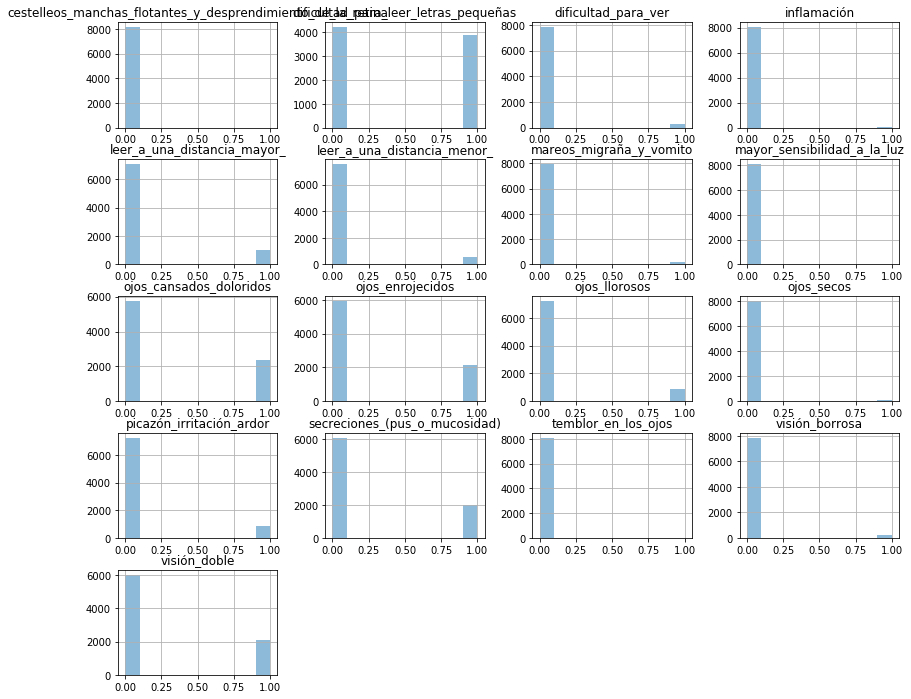

In [86]:
optometria_dep[['picazón_irritación_ardor', 'ojos_cansados_doloridos', 'ojos_llorosos', 'ojos_secos', 'visión_borrosa', 'visión_doble',  'mayor_sensibilidad_a_la_luz', 'dificultad_para_ver', 'dificultad_para_leer_letras_pequeñas', 'leer_a_una_distancia_mayor_', 'secreciones_(pus_o_mucosidad)', 'leer_a_una_distancia_menor_', 'ojos_enrojecidos', 'mareos_migraña_y_vomito', 'inflamación', 'temblor_en_los_ojos',        'cestelleos_manchas_flotantes_y_desprendimiento_de_la_retina']].hist(alpha = 0.5, figsize = (14,12))

Los histogramas de los verbatims de síntomas no son concluyentes.


REDUCCION DE CARACTERISTICAS 

Una vez se ha revisado la información contenida en cada una de las columnas del dataframe y aplicado limpieza sobre ellas, se procede a realizar análisis de las dimensiones

De la limpieza de datos se concluye:

- La variable Enfermedad se abre en tres variables:

  * Hipertensión
  * Glaucoma
  * Diabetes

- Todos los valores 'na' de las mediciones no pueden ser interpretados como valores cero

- Dado que el campo consulta indica si recibio consulta o no y para los datos del dataframe no hay varibilidad mostrada con una desviación estándar igual a cero, esta columna puede ser eliminada

- Las columnas de montura y estuche y paño juntas significa que una persona luego de ser atendido por el optómetra le fueron recetados lentes, esta información se consolida en requiere_gafas

- Las características genero, usa_gafas, exam_ojos, tiem_gafas, pueden ser eliminadas ya que fueron numerizadas.

In [0]:
optometria_dep.drop(['enfermedad','consulta','montura', 'estuche y paño', 'genero', 'usa_gafas', 'exam_ojos', 'tiem_gafas'], axis = 1, inplace = True)

Construcción de la variable objetivo

Pacientes con diagnóstio principal Astigmatismo (H522 de acuerdo al CIE-10)

In [0]:
#1 Tiene astigmatismo como diagnóstico principal, 0 No
optometria_dep['astigmatismo'] = np.where(optometria_dep['diagnostico'] == 'H522',1,0) 
#H522 astigmatismo
#H521 miopia
#H524 presbicia 

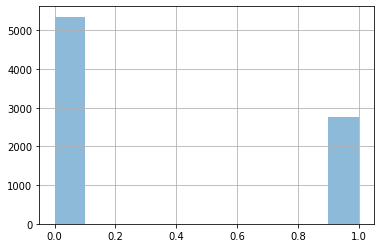

In [89]:
#Distribución de las clases
optometria_dep['astigmatismo'].hist(alpha = 0.5)

Las clases estan desbalanceadas, es importante al aplicar un modelo de machine learning balancear las clases

In [0]:
#Se elimina la caracteríticas diagnóstico ya que redunda con la variable objetivo
optometria_dep.drop(['diagnostico'], axis = 1, inplace = True)

Dado que varias de las variables de medición óptica esan de tipo object y para efectos del balanceo deben ser númericas, se hace la conversión

In [0]:
optometria_dep['esfera-od'] = optometria_dep['esfera-od'].astype(float)
optometria_dep['cilindro-od'] = optometria_dep['cilindro-od'].astype(float)
optometria_dep['eje-od'] = optometria_dep['cilindro-od'].astype(float)
optometria_dep['add-od'] = optometria_dep['add-od'].astype(float)
optometria_dep['esfera-oi'] = optometria_dep['esfera-oi'].astype(float)
optometria_dep['cilindro-oi'] = optometria_dep['cilindro-oi'].astype(float)
optometria_dep['eje-oi'] = optometria_dep['eje-oi'].astype(float)
optometria_dep['add-oi'] = optometria_dep['add-oi'].astype(float)

Análisis descriptivo de las variables una vez realizado la seleccón de caracteristicas

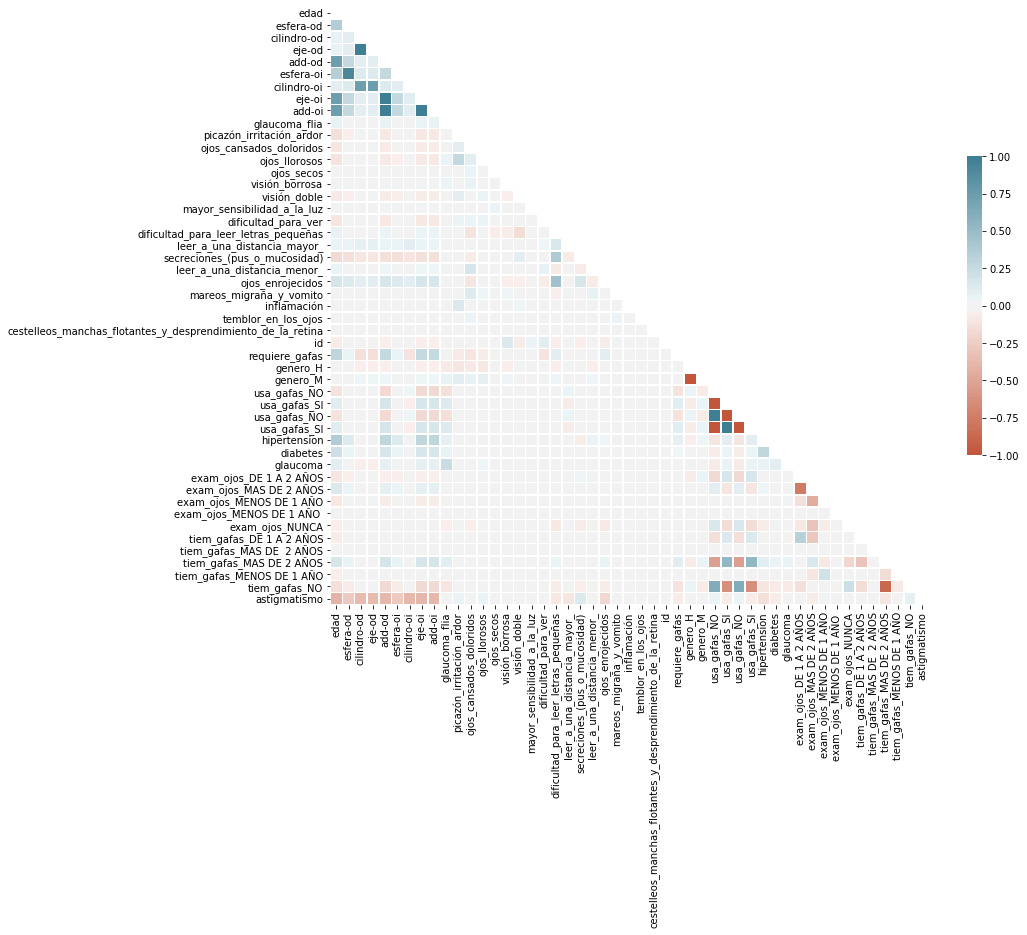

In [92]:
matriz_corr = optometria_dep.corr()
mask = np.triu(np.ones_like(matriz_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(14, 11))
cmap = sn.diverging_palette(20, 220, n = 200)
sn.heatmap(matriz_corr, mask = mask, cmap=cmap, vmin = -1, vmax = 1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Conclusiones matriz de correlación**

Correlaciones positivas
- edad y add-oi
- edad y add-od
- edad y eje-oi
- esfera-oi y esfera-od
- eje-od y cilindro-od
- add-od y eje-oi
- add-od y add-oi
- add-oi y eje-oi
- lente_EBC_od y lente_EBC_oi


Correlaciones negativas
- tiem_gafas_MAS DE 2 AÑOS y tiem_gafas_NO
- genero_H y genero_M
- usa_gafas_NO y usa_gafas_SI

Se procede a realizar un análisis gráfico de cada uno das dimensiones para complementar los hallazgos dado por la matriz de confusión.

Análisis grafico 

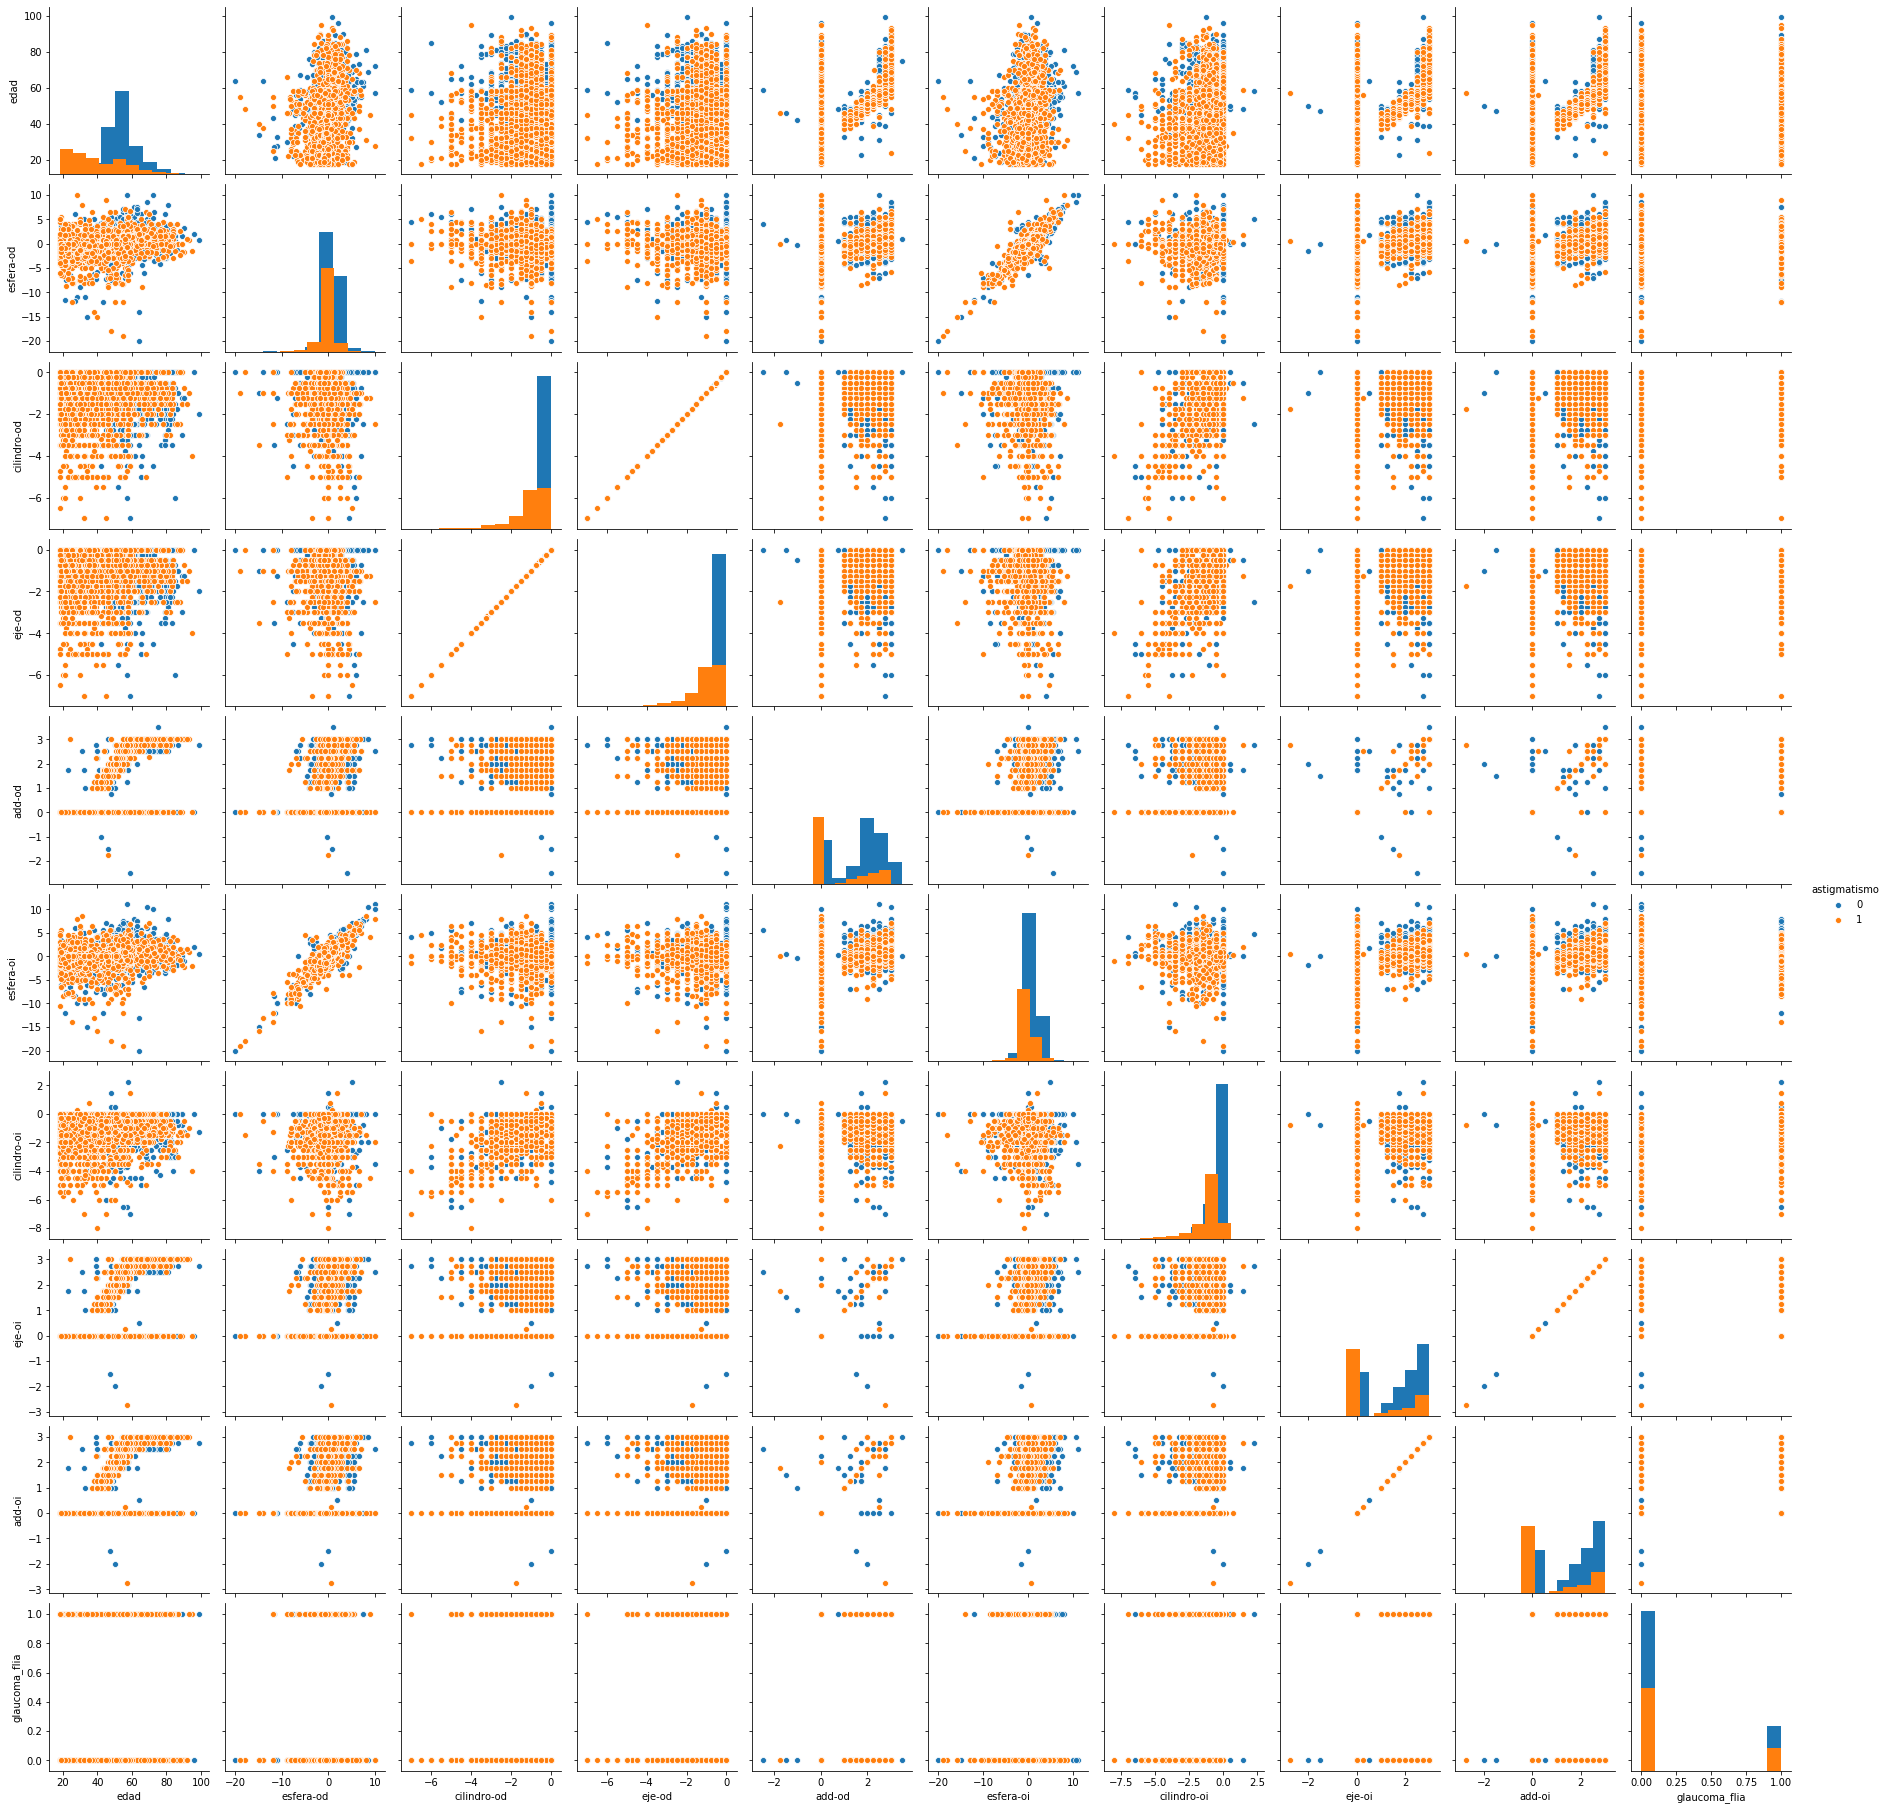

In [93]:
sn.pairplot(optometria_dep[['edad', 'esfera-od', 'cilindro-od', 'eje-od', 'add-od', 'esfera-oi','cilindro-oi', 'eje-oi', 'add-oi', 'glaucoma_flia','astigmatismo']], hue = 'astigmatismo', diag_kind = 'hist')

In [0]:
#A partir del gráfico anterior, se concluye que el glaucoma familiar no describe el astigmatismo, al igual que las esferas, por lo tanto se pueden eliminar del dataset

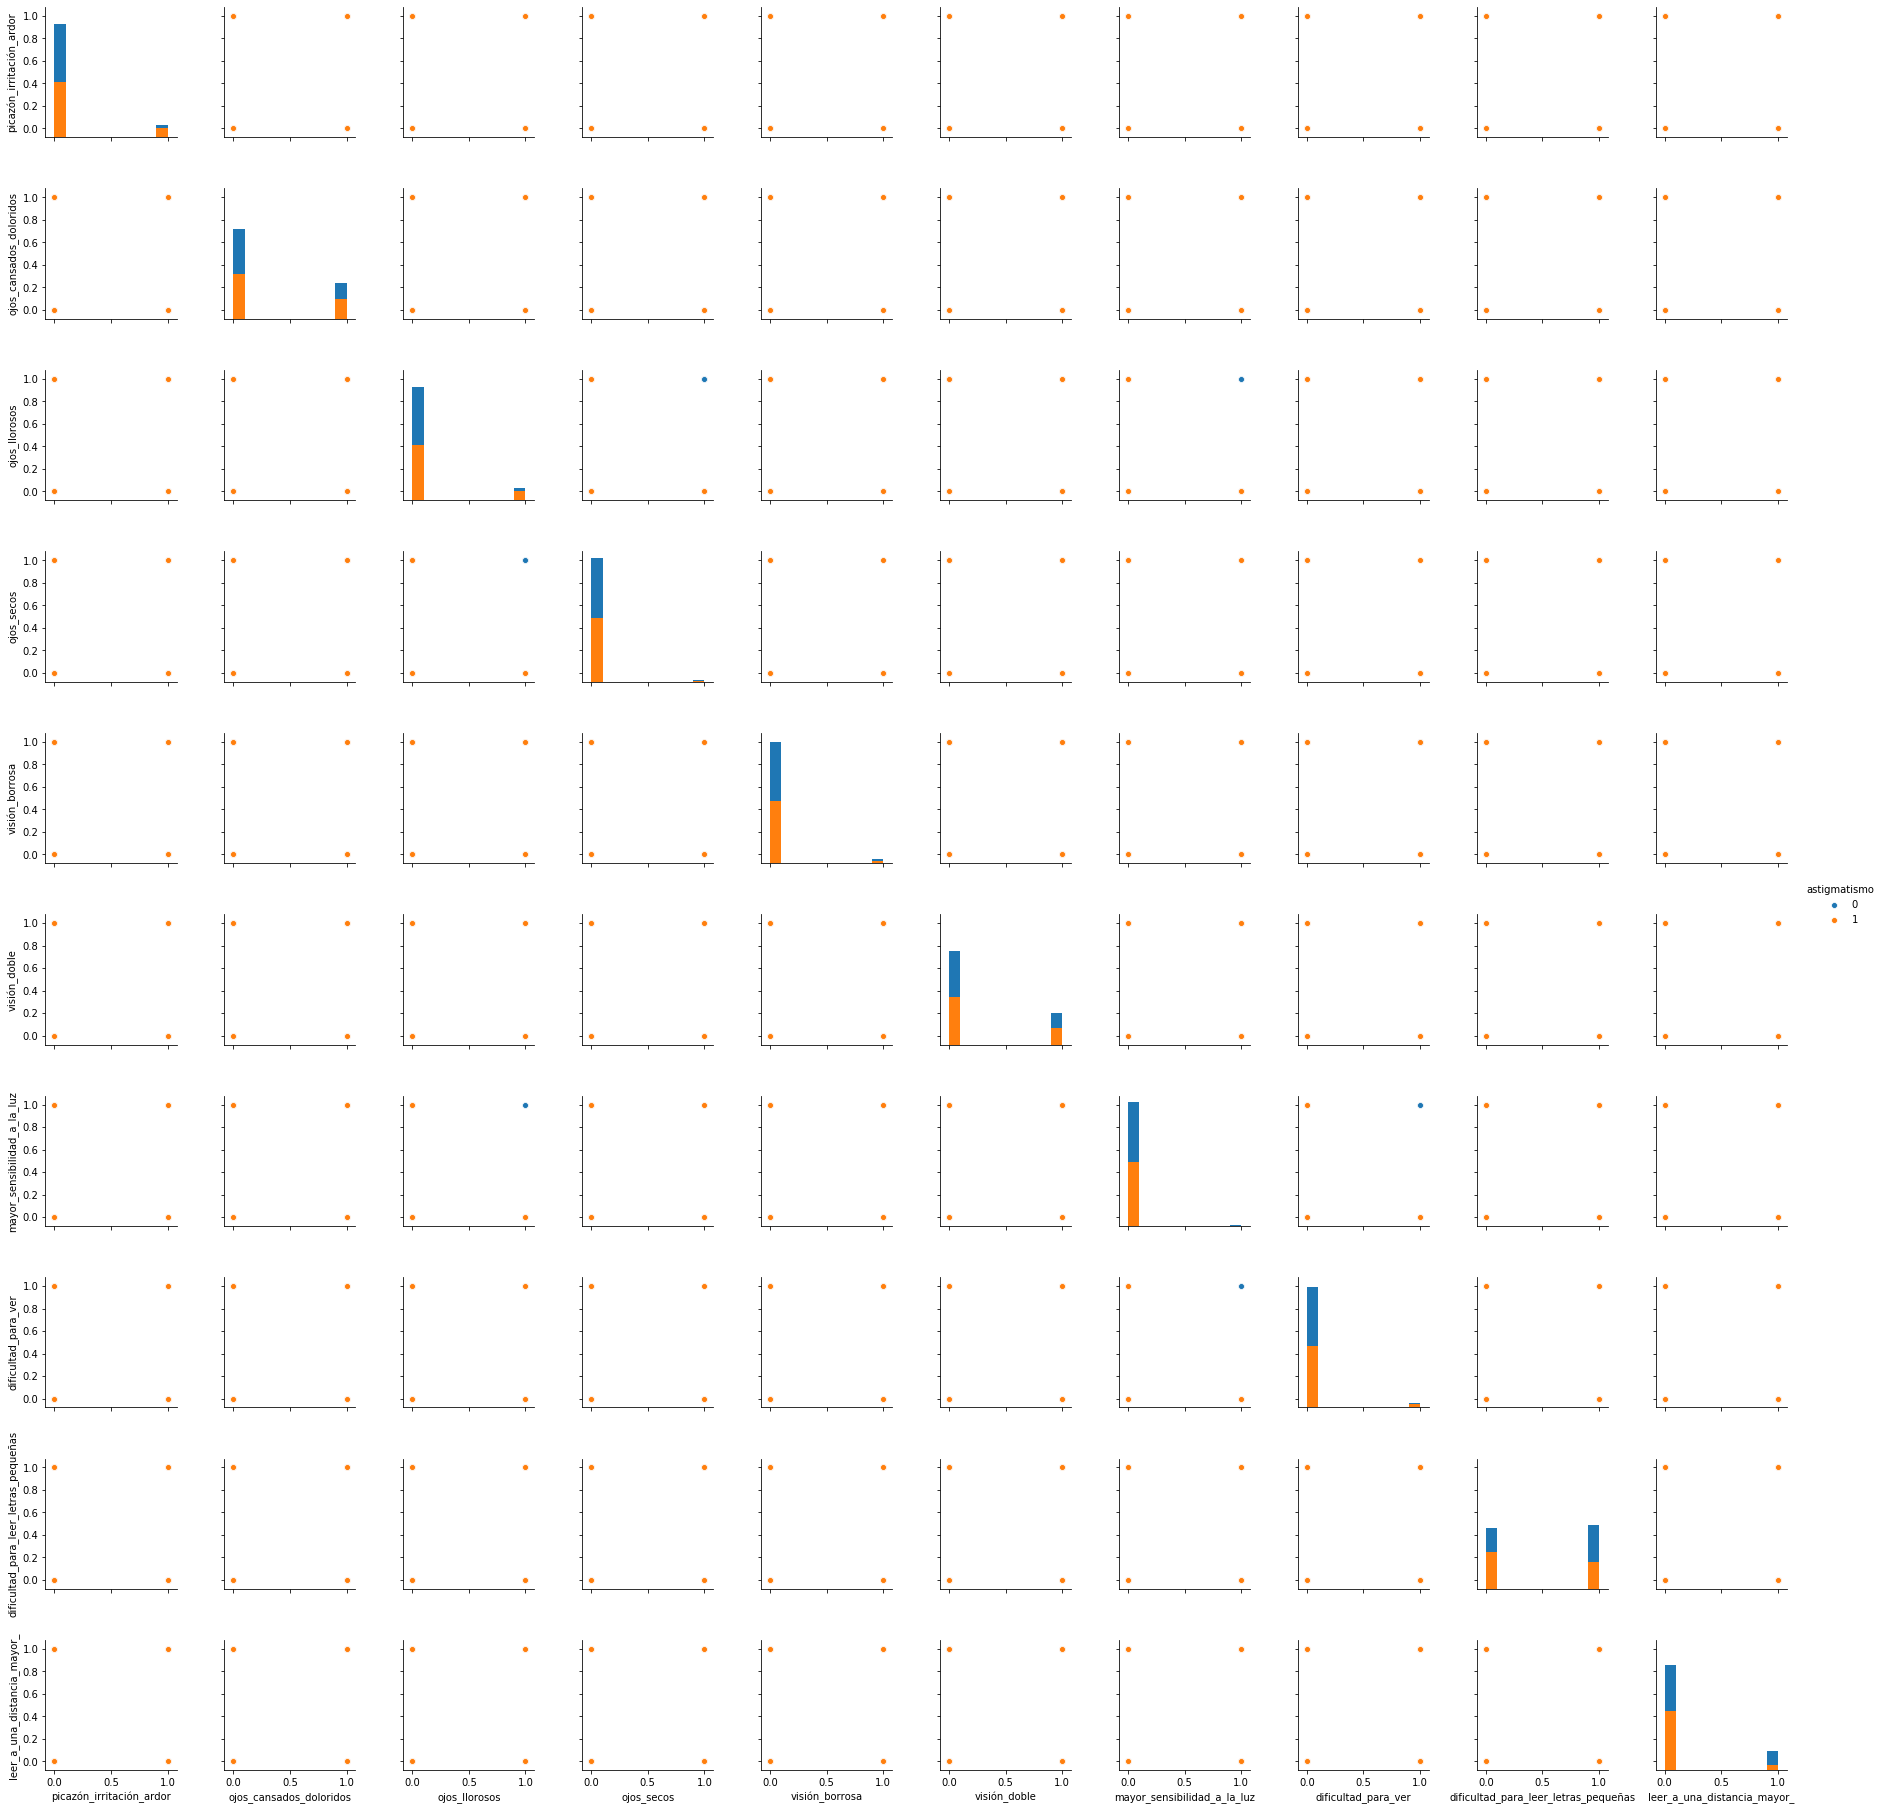

In [94]:
sn.pairplot(optometria_dep[['picazón_irritación_ardor', 'ojos_cansados_doloridos', 'ojos_llorosos',
       'ojos_secos', 'visión_borrosa', 'visión_doble', 'mayor_sensibilidad_a_la_luz', 'dificultad_para_ver',
       'dificultad_para_leer_letras_pequeñas', 'leer_a_una_distancia_mayor_', 'astigmatismo']], hue = 
       'astigmatismo', diag_kind = 'hist')

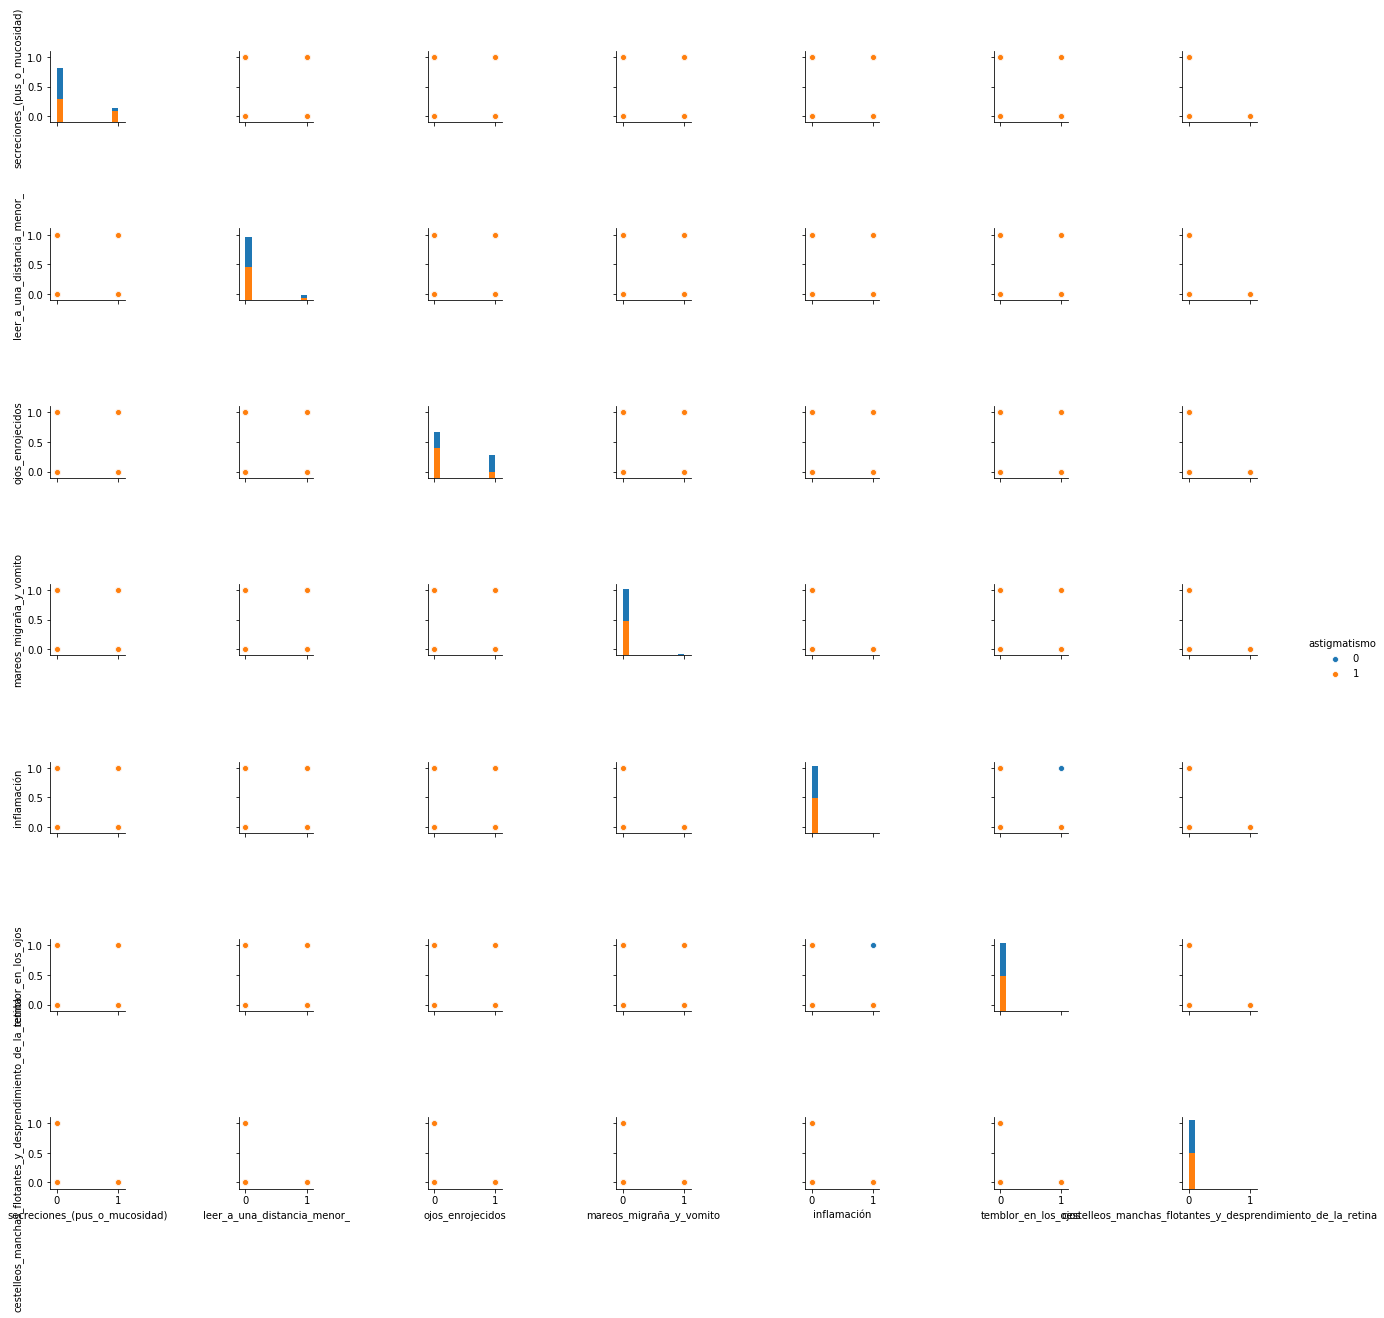

In [95]:
sn.pairplot(optometria_dep[['secreciones_(pus_o_mucosidad)', 
       'leer_a_una_distancia_menor_', 'ojos_enrojecidos', 'mareos_migraña_y_vomito', 'inflamación',
       'temblor_en_los_ojos', 'cestelleos_manchas_flotantes_y_desprendimiento_de_la_retina', 'astigmatismo']], hue = 
       'astigmatismo', diag_kind = 'hist')

Las sintomatologías anteriores no describe el astigmatimo, por lo cual se pueden eliminar del dataset

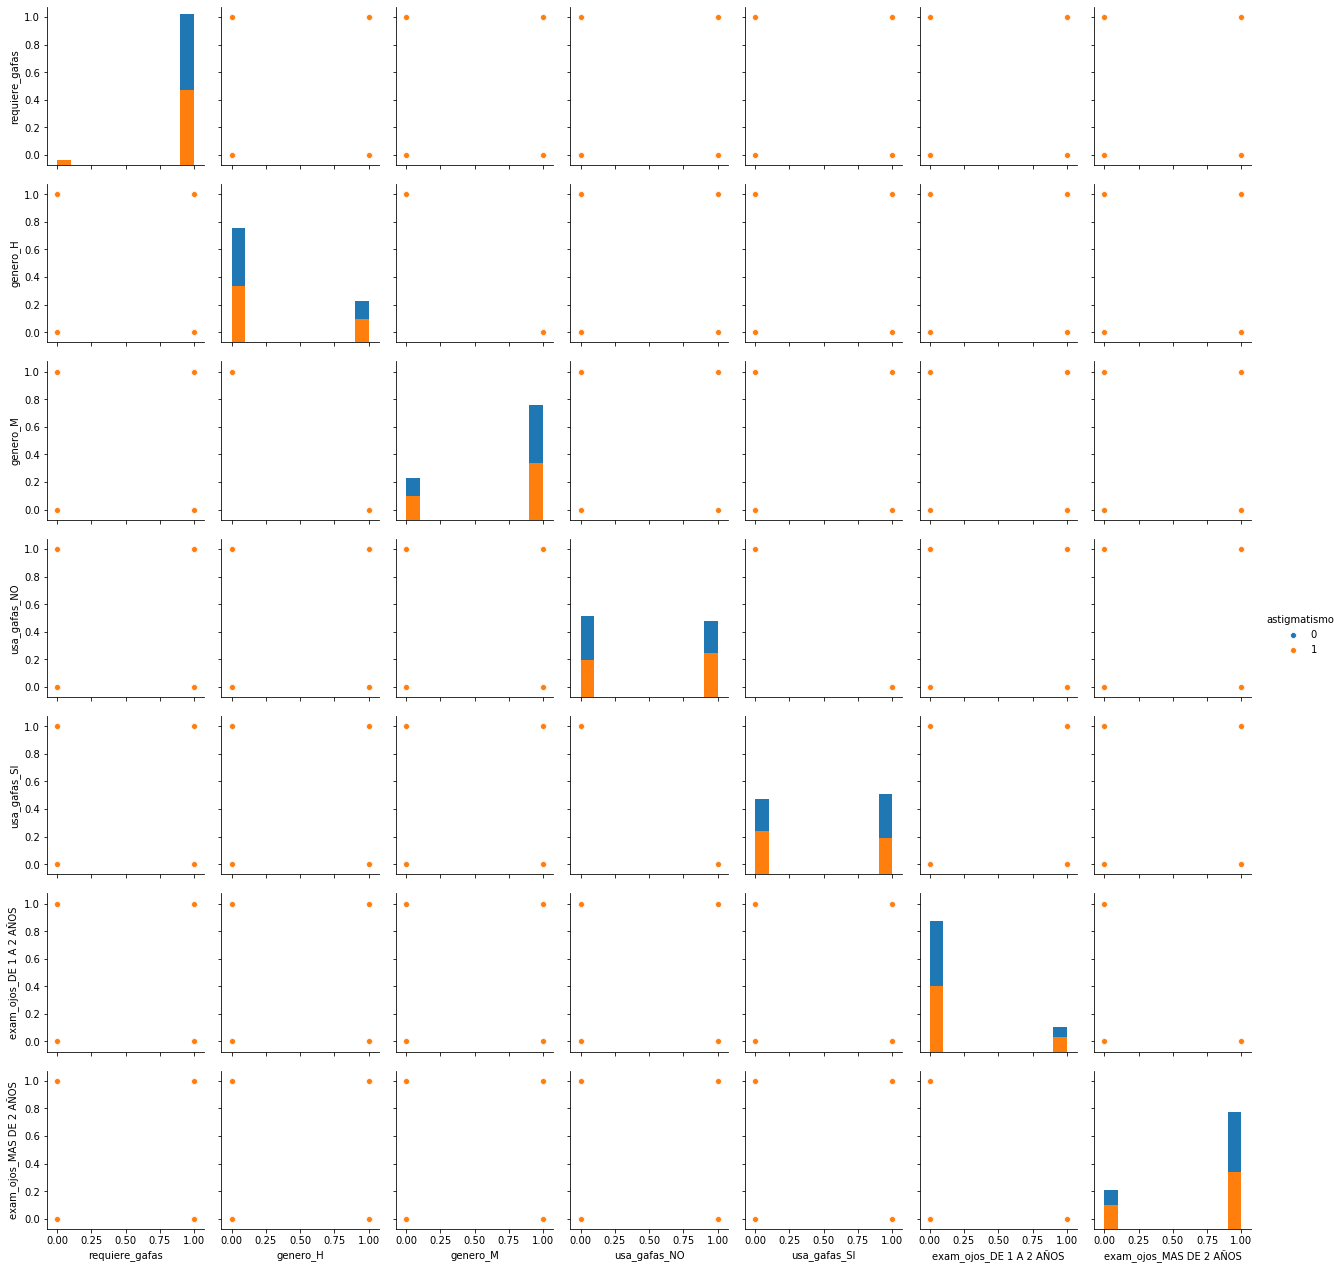

In [150]:
sn.pairplot(optometria_dep[['requiere_gafas', 'genero_H', 'genero_M', 'usa_gafas_NO',
'usa_gafas_SI', 'hipertension', 'diabetes', 'glaucoma', 'exam_ojos_DE 1 A 2 AÑOS', 'exam_ojos_MAS DE 2 AÑOS',
'astigmatismo']], hue = 'astigmatismo', diag_kind = 'hist')

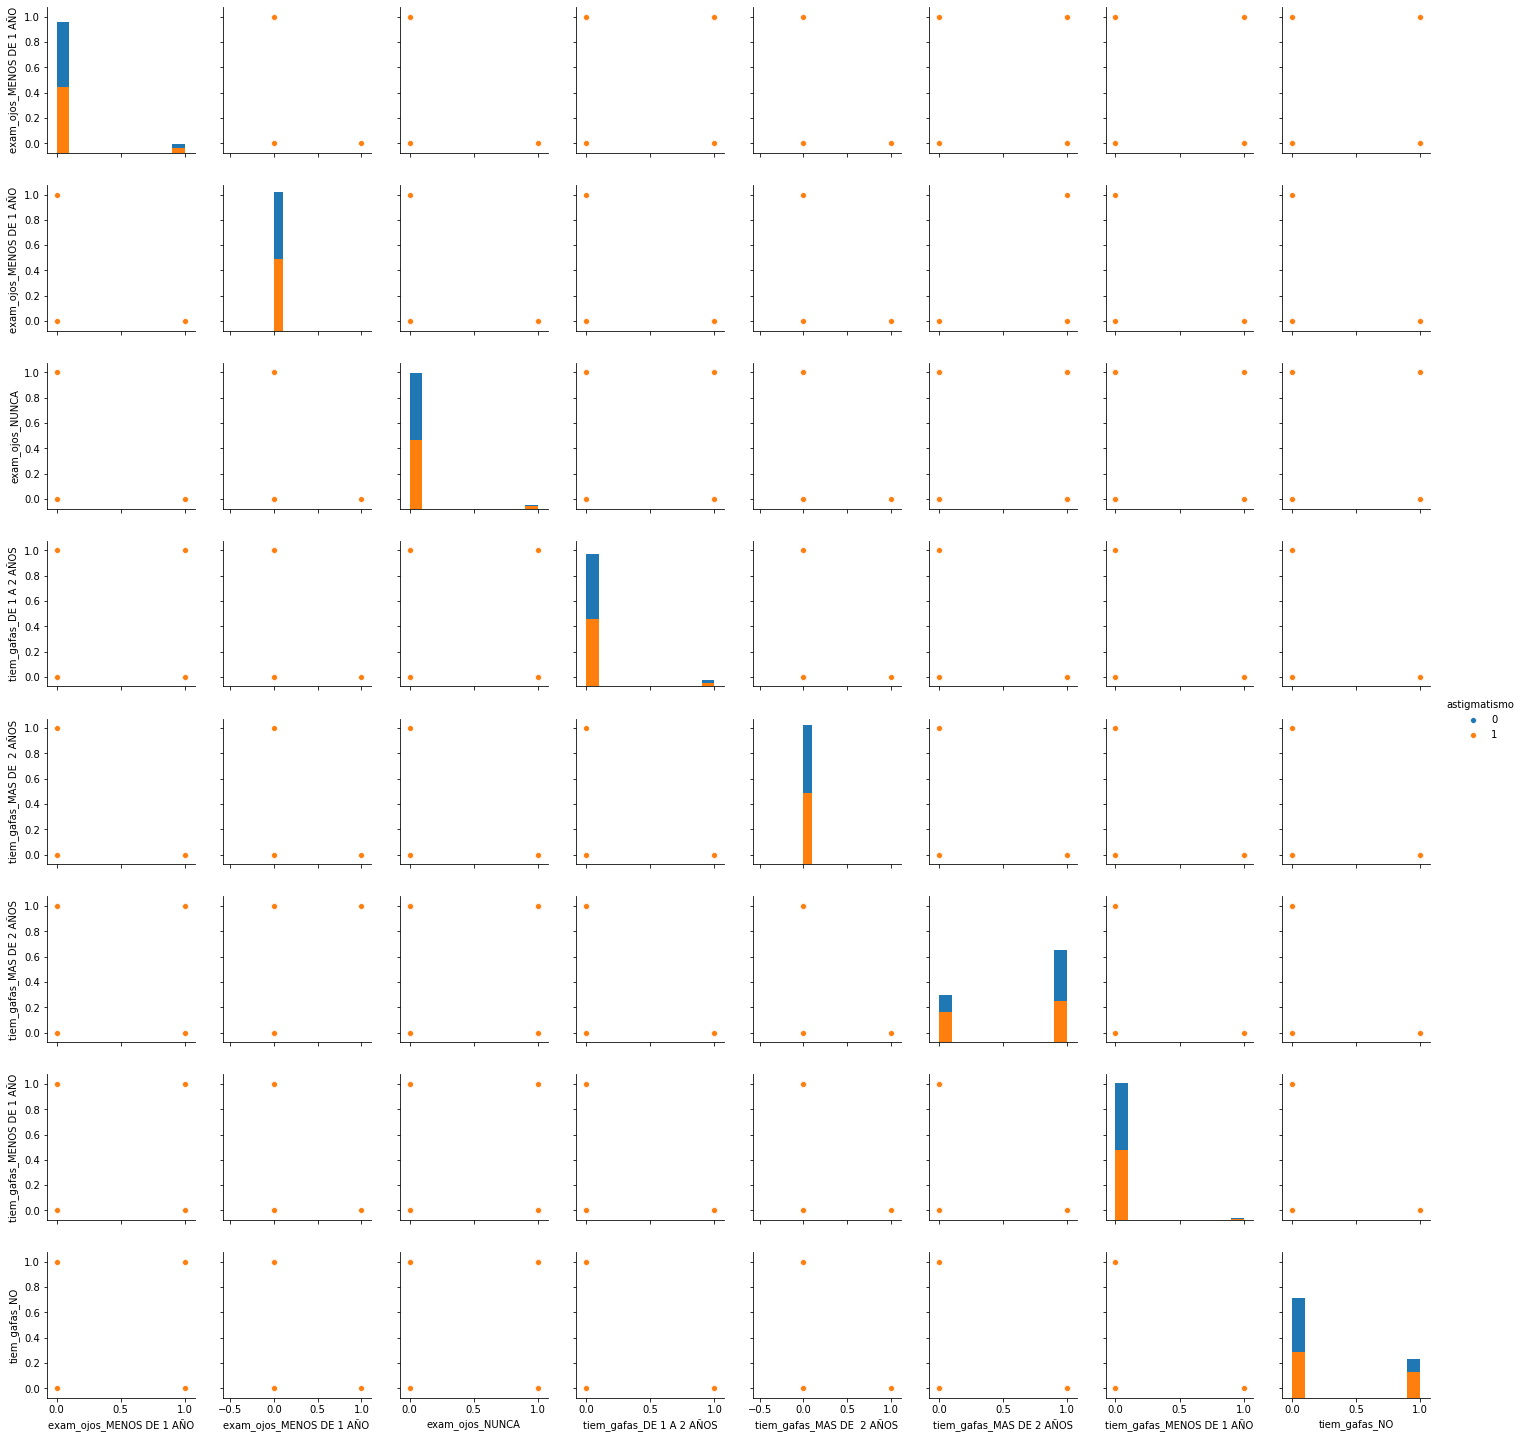

In [98]:
sn.pairplot(optometria_dep[['exam_ojos_MENOS DE 1 AÑO', 'exam_ojos_MENOS DE 1 AÑO ',
       'exam_ojos_NUNCA', 'tiem_gafas_DE 1 A 2 AÑOS',
       'tiem_gafas_MAS DE  2 AÑOS', 'tiem_gafas_MAS DE 2 AÑOS',
       'tiem_gafas_MENOS DE 1 AÑO', 'tiem_gafas_NO', 'astigmatismo']], hue = 
       'astigmatismo', diag_kind = 'hist')

In [0]:
#De acuerdo al análisis gráfico de las caracteristicas anteriores, se concluyen como relevantes: 
#tiem_gafas_MAS DE 2 AÑOS
#exam_ojos_MENOS DE 1 AÑO
#por lo tanto se dejan como parte del dataset

In [0]:
columnas = ['edad', 'cilindro-od', 'eje-od', 'add-od', 'cilindro-oi', 'eje-oi', 'add-oi', 'tiem_gafas_MAS DE 2 AÑOS', 'exam_ojos_MENOS DE 1 AÑO ', 'astigmatismo']

In [0]:
optometria = optometria_dep[columnas]

**Extracción de caracteristicas usando:**

- Árbol de decisión
- Bosque aleatorio
- PCA

División de datos de entrenamiento y prueba

In [0]:
modelos_vbles = optometria.drop('astigmatismo', axis = 1)
X = modelos_vbles
y = optometria.astigmatismo
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 1, stratify = y)

Balanceo de Clases

In [0]:
sm = SMOTE(random_state = 0)
x_est, y_est = sm.fit_sample(x_train, y_train)

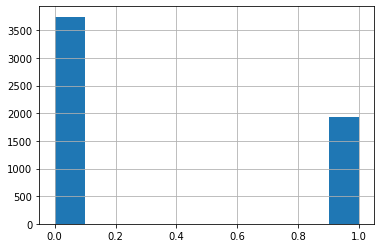

In [0]:
#Antes de balancear
y_train.hist()

6439    0
1362    1
2769    0
925     1
3049    0
       ..
259     0
1901    0
5047    1
999     1
3390    0
Name: astigmatismo, Length: 5677, dtype: int32

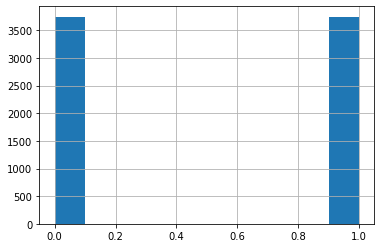

In [0]:
#Después de balancear
y_est.hist()

Selección de caracteristicas usando **arboles de decisiones**

Las variable que tiene aportan a los datos más importancia son edad, cilindro-od, eje-od, cilindro-oi. Por su lado exam_ojos_MENOS DE 1 AÑO no tiene ningún peso.

In [0]:
arbol = DecisionTreeClassifier(criterion= 'entropy',random_state=0)
arbol.fit(x_est, y_est)
y_pred = arbol.predict(x_test)

In [0]:
print("Accuracy:",metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.8388820386354295


Del árbol de decisión, las variable que tiene aportan a los datos más importancia son edad, cilindro-od, eje-od, cilindro-oi. Por su lado exam_ojos_MENOS DE 1 AÑO no tiene ningún peso.

In [0]:
mask = arbol.feature_importances_ > 0.05
reduced_X = X.loc[:,mask]
print(reduced_X.columns)

Index(['edad', 'cilindro-od', 'eje-od', 'cilindro-oi'], dtype='object')


In [0]:
print(dict(zip(X.columns, arbol.feature_importances_.round(2))))

{'edad': 0.31, 'cilindro-od': 0.1, 'eje-od': 0.06, 'add-od': 0.03, 'cilindro-oi': 0.42, 'eje-oi': 0.02, 'add-oi': 0.03, 'tiem_gafas_MAS DE 2 AÑOS': 0.03, 'exam_ojos_MENOS DE 1 AÑO ': 0.0}


Selección de caracteristicas con **Bosque Aleatorio**

Para bosques aleatorios, las variables con mayor importancia son edad, cilindro-od, eje-od, cilindro-oi. Aquí tanto tiem_gafas_MAS DE 2 AÑOS y exam_ojos_MENOS DE 1 AÑO  no tienen relevancia.

In [0]:
rf = RandomForestClassifier(random_state=0)
rf.fit(x_est, y_est)
mask_rf = rf.feature_importances_.round(2) > 0.05
print(dict(zip(X.columns, mask_rf)))

{'edad': True, 'cilindro-od': True, 'eje-od': True, 'add-od': False, 'cilindro-oi': True, 'eje-oi': False, 'add-oi': False, 'tiem_gafas_MAS DE 2 AÑOS': False, 'exam_ojos_MENOS DE 1 AÑO ': False}


Selección de caracteristica con **PCA**

In [0]:
#Escalar los datos
x = StandardScaler().fit_transform(X)

Se revisa que la normalización de los datos tengan media cero y desviación estandar de uno

In [0]:
print('Media: ', np.mean(x))
print('Desviación estándar: ', np.std(x))

Media:  -1.1097667060782494e-17
Desviación estándar:  1.0


In [0]:
pca_opt = PCA(n_components=2)
principalComponents = pca_opt.fit_transform(x)

In [0]:
optometria_PCA = pd.DataFrame(data = principalComponents, columns = ['PCA1', 'PCA2'])

In [0]:
optometria_PCA.head(2)

,PCA1,PCA2
0,1.540353,-0.809010
1,2.483970,-0.886359


In [0]:
explained_variance = np.var(principalComponents, axis=0)
explained_variance_ratio = explained_variance / np.sum(explained_variance)
#print('Varianza: ', explained_variance)
print('Ratio de varianza ',explained_variance_ratio)

Ratio de varianza  [0.59409296 0.40590704]


El componente 1 explica el 59% de la información mientras que el componente 2 contiene 40% de la información. Proyectar la data a dos dimensiones se pierde casi el 1% de información.

Conocer el número de componentes óptimos:

In [0]:
print(pd.DataFrame(pca_opt.components_, columns = X.columns, index = ['PCA1','PCA2']))

edad  cilindro-od    eje-od    add-od  cilindro-oi    eje-oi  \
PCA1 -0.420927    -0.163915 -0.163915 -0.492394    -0.163517 -0.493182   
PCA2  0.124930    -0.574398 -0.574398  0.139814    -0.506615  0.140899   

        add-oi  tiem_gafas_MAS DE 2 AÑOS  exam_ojos_MENOS DE 1 AÑO   
PCA1 -0.493182                 -0.115596                   0.008643  
PCA2  0.140899                  0.092814                  -0.000950  


Por árboles de decisión, random forest y PCA se eliminan las variables exam_ojos_MENOS DE 1 AÑO y tiem_gafas_MAS DE 2 AÑOS, ya que su factor de importancia tiende a cero 

In [0]:
columnas = ['edad', 'cilindro-od', 'eje-od', 'add-od', 'cilindro-oi', 'eje-oi', 'add-oi', 'astigmatismo']
optometria = optometria[columnas]

Ejecución del modelo de clasificación con las caracteristicas seleccionadas luego de realizar la selección de caracteristicas por medio de análisis descriptivo y ejecución de modelos de ML

In [0]:
# Se vuelve a calcular los datos de entrenamiento y prueba para efectos de los modelos de clasificación con las variables seleccionadas

modelos_vbles = optometria.drop('astigmatismo', axis = 1)
X_ast = modelos_vbles
y_ast = optometria.astigmatismo

# Normalizar la data
sc = StandardScaler()
X_ast = sc.fit_transform(X_ast)

x_train_ast, x_test_ast, y_train_ast, y_test_ast = train_test_split(X_ast, y_ast, test_size = 0.3, random_state = 1, stratify = y_ast)

In [0]:
# Se balancean nuevamente las clases con los datos recién particionado

sm_ast = SMOTE(random_state = 0)
x_est_ast, y_est_ast = sm_ast.fit_sample(x_train_ast, y_train_ast)

### **Árbol de decisiones**

In [0]:
random.seed(1988)
from sklearn.model_selection import cross_val_predict
arbol_ast = DecisionTreeClassifier(criterion = 'entropy',random_state=0)
arbol_ast.fit(x_est_ast, y_est_ast)
y_pred_arbol = arbol_ast.predict(x_test_ast)

Text(33.0, 0.5, 'Real')

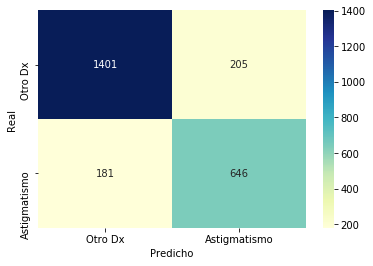

In [0]:
rarbol_cm = confusion_matrix(y_test_ast, y_pred_arbol)
sn.heatmap(rarbol_cm, fmt='', annot = True, cmap = 'YlGnBu', xticklabels = ["Otro Dx", "Astigmatismo"], yticklabels = ["Otro Dx", "Astigmatismo"])
plt.xlabel('Predicho')
plt.ylabel('Real')

In [0]:
print(classification_report(y_test_ast, y_pred_arbol))

precision    recall  f1-score   support

           0       0.89      0.87      0.88      1606
           1       0.76      0.78      0.77       827

    accuracy                           0.84      2433
   macro avg       0.82      0.83      0.82      2433
weighted avg       0.84      0.84      0.84      2433



Por árboles de decisión tenemos que el modelo es efectivo en un 84%. Sin embargo tenemos que de 827 personas cuyo síntoma principal es astigmatismo sol un 78% de esta población fue clasificado correctamente

### **Regresión lógistica**

In [0]:
random.seed(1988)
logreg = LogisticRegression()
logreg.fit(x_est_ast, y_est_ast)
y_pred_log = logreg.predict(x_test_ast)

Text(33.0, 0.5, 'Real')

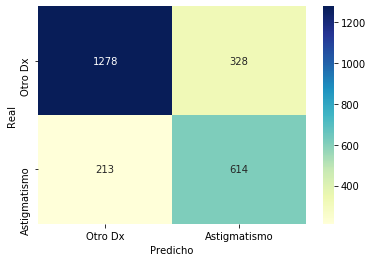

In [0]:
rlog_cm = confusion_matrix(y_test_ast, y_pred_log)
sn.heatmap(rlog_cm, fmt='', annot = True, cmap = 'YlGnBu', xticklabels = ["Otro Dx", "Astigmatismo"], yticklabels = ["Otro Dx", "Astigmatismo"])
plt.xlabel('Predicho')
plt.ylabel('Real')

In [0]:
print(classification_report(y_test_ast, y_pred_log))

precision    recall  f1-score   support

           0       0.86      0.80      0.83      1606
           1       0.65      0.74      0.69       827

    accuracy                           0.78      2433
   macro avg       0.75      0.77      0.76      2433
weighted avg       0.79      0.78      0.78      2433



Por regresión lógistica, a partir de la matriz de confusión tenemos:

De 1606 pacientes cuyo diagnóstico principal no era astigmatismo, el modelo dijo que efectivamente no el diagnóstico principal no correspondía a astigmatismo 1277, equivale a un 70%, se equivoco en 329 pacientes a los cuales les dijo que si tenían astigmatismo, lo cual equivale a un 20%
Para los pacientes con astigmatismo, en total se tenían 827 personas, el modelo predice que de esos 827 pacientes, 212 no tiene astigmatismo (25%) y 615 si lo tenían (74%).

Si bien las métricas con este modelo sin utilizar cross validation (por efectos del ejercicio académico) son bajas, se concluye:
* En un 78% el modelo predice bien las clases astigmatismo y no astigmatismo (accuracy). 
* En un 74% el modelo clasificó correctamente la clase de astigmatismo para todos los valores que realmente eran astigmatismo (recall). Esto significa que 212 pacientes se quedaron sin recibir un diagnóstico correcto de un total de 827 personas.
* De los valores que el modelo catalogó como astigmatismo, un 65% de ellos realmente eran astigmatismo (precision). En este caso, se diagnóstico como astigmatismo en su diagnóstico principal a 329 pacientes, lo cual no es correcto.




### Random Forest

In [0]:
random.seed(2020)
randomForest = RandomForestClassifier()

randomForest = RandomForestClassifier(random_state=0) 
randomForest.fit(x_est_ast, y_est_ast)
pred_y_rf = randomForest.predict(x_test_ast)

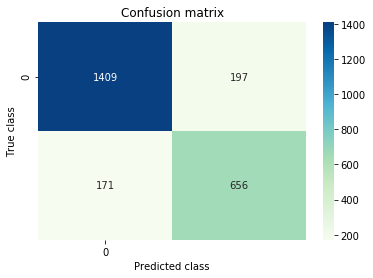

precision    recall  f1-score   support

           0       0.89      0.88      0.88      1606
           1       0.77      0.79      0.78       827

    accuracy                           0.85      2433
   macro avg       0.83      0.84      0.83      2433
weighted avg       0.85      0.85      0.85      2433



In [0]:
conf_matrix = confusion_matrix(y_test_ast, pred_y_rf)
sn.heatmap(conf_matrix,xticklabels=2, yticklabels=2, annot=True, fmt= "", cmap="GnBu");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()
print (classification_report(y_test_ast, pred_y_rf))
    


Conclusiones

La clase cuyo DX ppal no era astigmatismo tuvo 1409 aciertos en la clasificacion de casos y 197 fallos, clasificando estos con astigmatismo como DX ppal, es decir, el porcetaje de clasificacion errada para esta clase fue de  12,3%. Para los pacientes con astigmatismo como diagnostico ppal 827 el porcentaje de clasificacion errado fue de 20,7%

El accuracy para el modelo implementado a través del algoritmo Random Forest indica que el porcentaje de predicciones correctas es de un 85 %, esto tanto para personas que presenta astigmatismo como diagnostico principal como para aquellas cuyo diagnostico principal no es el astigmatismo

El recall para nuestro modelo fue de 88% y 79% para casos cuyo diagnostico principal era el astigmatismo y para casos cuyo diagnostico principal no era el astigmatismo respectivamente, esto es, el modelo en los casos de pacientes que no presentan astigmatismo como DX ppal puede detectar el 88% de los casos y para pacientes que presentan astigmatismo como DX ppal será efectivo en un 79% de eventos.

La Precisión define cuan confiable es un modelo en responder si un punto pertenece a una clase, para este caso esta medida esta en 89% y 77% para casos cuyo DX ppal era el astigmatismo y para casos cuyo DX ppal no era el astigmatismo respectivamente

### Redes Neuronales full conect

In [0]:
#A partir de PCA se intenta entrenar el modelo.

modelos_vbles = optometria.drop('astigmatismo', axis = 1)
n_pca = 7
X = modelos_vbles
Y = optometria.astigmatismo
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 1, stratify = y)

  #Se balancean las clases
sm = SMOTE(random_state = 0)
x_est, y_est = sm.fit_sample(x_train, y_train)

  #Se obtienen los componentes principales
scaler = StandardScaler();
x = scaler.fit_transform(x_est);
x_test_scale = scaler.transform(x_test) 
from sklearn.decomposition import PCA
pca_opt = PCA(n_components=n_pca)
x_pca = pca_opt.fit_transform(x)

x_train_pca = x_pca
x_test_pca = pca_opt.transform(x_test_scale)

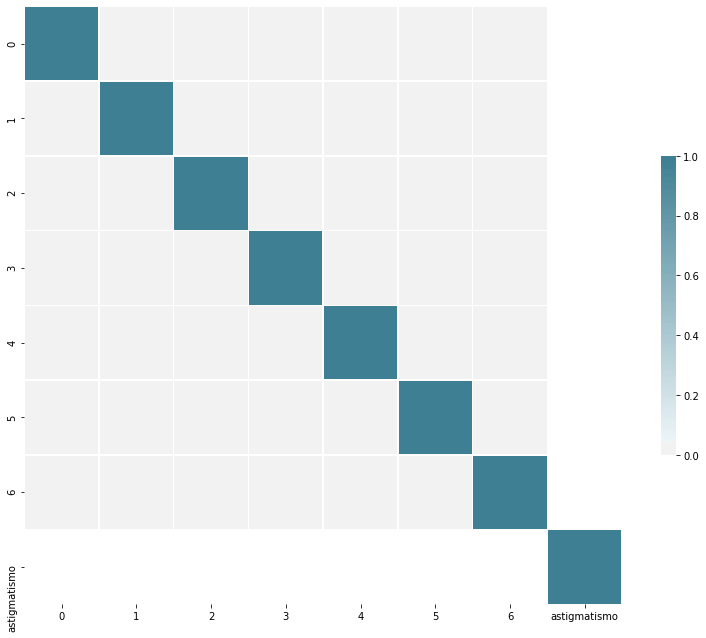

In [0]:
df_pca = pd.concat([pd.DataFrame(x_train_pca),pd.DataFrame(y_train)])
matriz_corr = df_pca.corr()
#mask = np.triu(np.ones_like(matriz_corr, dtype=np.bool))
f, ax = plt.subplots(figsize=(14, 11))
cmap = sn.diverging_palette(20, 220, n = 200)
map = sn.diverging_palette(20, 220, n = 200)
sn.heatmap(matriz_corr, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

A partir de la matriz de correlación, se evidencia que PCA elimina las correlaciones entre los componente

In [0]:
#Creamos un modelo de red neuronal
model = keras.Sequential([
  
    keras.layers.Dense(10, input_dim = n_pca, activation=tf.nn.relu),
    keras.layers.Dense(40, activation=tf.nn.relu),
    keras.layers.Dense(1, activation=keras.activations.hard_sigmoid
  )
  ])

#Configruamos el modelo
model.compile(optimizer='adam', 
                loss='binary_crossentropy',
                metrics=['accuracy'])

#Entrenamos el modelo
model.fit(x_train_pca, y_est, epochs = 100)

Train on 7494 samples
Epoch 1/100
7494/7494 [==============================] - 1s 166us/sample - loss: 0.5149 - accuracy: 0.7334
Epoch 2/100
7494/7494 [==============================] - 1s 103us/sample - loss: 0.4102 - accuracy: 0.7820
Epoch 3/100
7494/7494 [==============================] - 1s 123us/sample - loss: 0.3822 - accuracy: 0.7893
Epoch 4/100
7494/7494 [==============================] - 1s 129us/sample - loss: 0.3810 - accuracy: 0.7917
Epoch 5/100
7494/7494 [==============================] - 1s 123us/sample - loss: 0.3782 - accuracy: 0.7984
Epoch 6/100
7494/7494 [==============================] - 1s 105us/sample - loss: 0.3748 - accuracy: 0.8010
Epoch 7/100
7494/7494 [==============================] - 1s 117us/sample - loss: 0.3729 - accuracy: 0.8012
Epoch 8/100
7494/7494 [==============================] - 1s 98us/sample - loss: 0.3731 - accuracy: 0.7985
Epoch 9/100
7494/7494 [==============================] - 1s 101us/sample - loss: 0.3736 - accuracy: 0.8002
Epoch 10/100
749

In [0]:
test_loss, test_acc = model.evaluate(x_test_pca, y_test)

2433/2433 [==============================] - 0s 184us/sample - loss: 0.3603 - accuracy: 0.8339
Test accuracy:


In [0]:
y_predict = model.predict(x_test_pca)
y_bin = np.where(y_predict>0,1,0)
y_bin = y_predict.flatten()
y_bin = np.where(y_bin>0.5,1,0)

[Text(0, 0.5, 'Otro DX'), Text(0, 1.5, 'Astigmatismo')]

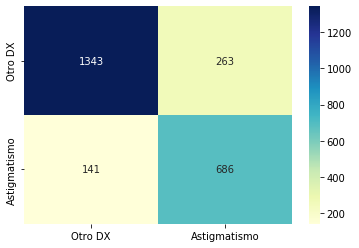

In [0]:
cm = confusion_matrix(y_test,y_bin)
ax = sn.heatmap(cm, fmt='', annot = True, cmap = 'YlGnBu', xticklabels=["Otro DX","Astigmatismo"],yticklabels=["Otro DX","Astigmatismo"])
ax.set_yticklabels(["Otro DX","Astigmatismo"],verticalalignment='center')

In [0]:
print(classification_report(y_test,y_bin))

precision    recall  f1-score   support

           0       0.90      0.84      0.87      1606
           1       0.72      0.83      0.77       827

    accuracy                           0.83      2433
   macro avg       0.81      0.83      0.82      2433
weighted avg       0.84      0.83      0.84      2433



### Conclusiones RNN Full Connect

La base de datos de test está compuesta por 2433 registros, un 34%(827) de los registros tienen como diagnóstico principal la enfermedad Astigmatismo, un 66% tienen un diagnóstico  princicipal diferente. Como una medida general del modelo se puede decir que clasifica con la etiqueta correcta (exactitud) en el 83% de los casos.

Para la clase astigmatismo se encuentra que el modelo presenta un precisión de 72%, esto quiere decir que cuando se predice astigmatismo como diagnóstico principal se acierta el 72%(686) de la veces. El recall presenta un valor de 83%, es decir, que de todos los pacientes con astigmatismo (827), como diagnóstico principal, clasifica correctamente el 83%(686) de estos.

A partir de la matriz de confusión se observa que el modelo con redes neuronales y PCA es capaz de diagnósticar correctamente un 83% (686) de todos los pacientes con Astigmatismo, esta medida es el recall. Sin embargo, en medicina tiene mucha importancia el número de pacientes, que aún teniendo una enfermedad, no son diagnosticados correctamente. En nuestro modelo el 17%(141) de pacientes que realmente tienen diagnóstico principal de astigmatismo no son correctamente clasificados. Sin embargo este modelo es el que tiene un menor número de pacientes con diagnóstico principal Astigmatismo mal clasificado, con respecto a los otros modelos (Árboles de decisión, Random Forest, Regresión Logística). 